# NEXT-100 Comissioning ($\alpha$ in Xe)

How do the commissioning plots change with variations in the data taking conditions (different runs)?
<br>
Be careful here, you will need to specify the type of scan in your comparison: **cath_HV** or **EL_HV**.

In [1]:
import crudo
import fit_functions as ff
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotting_tools as pt
import tables as tb
from   scipy.optimize import curve_fit

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Runs Information

In [8]:
# Select the type of scan in your comparison. If it is needed.
# scan, scan_key = "EL", "EL_HV"
# scan, scan_key = "Cathode", "cath_HV"

# Define the runs to be analyzed
runs_info = [
                # # Drift field scan: Oct 2024
                # {"run_number": 14440, "cath_HV": 18e3, "EL_HV": 6e3, "duration": 42952},
                # {"run_number": 14456, "cath_HV": 19e3, "EL_HV": 6e3, "duration": 56420},
                # {"run_number": 14468, "cath_HV": 20e3, "EL_HV": 6e3, "duration": 55696},
                # {"run_number": 14484, "cath_HV": 21e3, "EL_HV": 6e3, "duration": 48240},
                # {"run_number": 14489, "cath_HV": 22e3, "EL_HV": 6e3, "duration": 42314},
                # {"run_number": 14498, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 43161},
                # {"run_number": 14519, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 43274},
                # {"run_number": 14522, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 42801},
                # # Gas recirculation: Nov 2024
                # {"run_number": 14581, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 76086},
                # {"run_number": 14582, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 79541},
                # {"run_number": 14588, "cath_HV": 23e3, "EL_HV": 6e3, "duration": 55856},
                # # EL voltage scan: Dic 2024
                # {"run_number": 14601, "cath_HV": 23e3, "EL_HV": 7e3, "duration": 77537},
                # {"run_number": 14608, "cath_HV": 23e3, "EL_HV": 8e3, "duration": 86414},
                # {"run_number": 14704, "cath_HV": 23e3, "EL_HV": 9e3, "duration": 52765},
                # # EL voltage scan: Jan 2025
                # {"run_number": 14714, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 64527},
                # {"run_number": 14720, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 48518},
                # {"run_number": 14733, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 53881},
                # {"run_number": 14735, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 84987},
                # {"run_number": 14737, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 72705},
                # {"run_number": 14739, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 87138},
                # {"run_number": 14741, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 87755},
                # {"run_number": 14743, "cath_HV": 23e3, "EL_HV": 7.5e3, "duration": 82332},
    
                # # # # #  A L P H A   R U N S # # # # #
    
                # Jan 2025
                {"run_number": 14714, "duration": 64527, "OK": -1     , "LOST": -1     , "real_rate": -1    },
                # {"run_number": 14715, "duration": 84365, "OK": 2469062, "LOST": 2239303, "real_rate": 55.809},  # NO processed
                {"run_number": 14716, "duration": 17036, "OK": 495769 , "LOST": 451306 , "real_rate": 55.592},
                {"run_number": 14720, "duration": 48518, "OK": -1     , "LOST": -1     , "real_rate": -1    },
                {"run_number": 14733, "duration": 53881, "OK": 1587637, "LOST": 1429629, "real_rate": 55.998},
                {"run_number": 14735, "duration": 84987, "OK": 2508569, "LOST": 2267982, "real_rate": 56.203},
                {"run_number": 14737, "duration": 72705, "OK": 2153786, "LOST": 1960347, "real_rate": 56.586},
                {"run_number": 14739, "duration": 87138, "OK": 2576630, "LOST": 2334343, "real_rate": 56.358},
                {"run_number": 14741, "duration": 87755, "OK": 2592615, "LOST": 2349583, "real_rate": 56.318},
                {"run_number": 14743, "duration": 82332, "OK": 2437984, "LOST": 2220643, "real_rate": 56.583},
                {"run_number": 14745, "duration": 60990, "OK": 1803415, "LOST": 1636317, "real_rate": 56.398},
                # --- NO Cold Getter: Jan 27 --- #
                {"run_number": 14753, "duration": 86308, "OK": 2188547, "LOST": 1532351, "real_rate": 43.111},
                {"run_number": 14765, "duration": 55978, "OK": 1259832, "LOST": 735202 , "real_rate": 35.639},
                # {"run_number": 14776, "duration": 47397, "OK": 957081 , "LOST": 481810 , "real_rate": 30.358},  # Data removed
                # {"run_number": 14780, "duration": 88503, "OK": 1600797, "LOST": 682246 , "real_rate": 25.796},  # NO processed
                # Feb 2025
                {"run_number": 14782, "duration": 85654, "OK": 1382153, "LOST": 506234 , "real_rate": 22.046},
                {"run_number": 14784, "duration": 57290, "OK": 842541 , "LOST": 273581 , "real_rate": 19.481},
                {"run_number": 14789, "duration": 74148, "OK": 976360 , "LOST": 277504 , "real_rate": 16.910},
                # --- Zero Suppression --- #
                {"run_number": 14803, "duration": 71721, "OK": 933727 , "LOST": 104677 , "real_rate": 14.478},
                {"run_number": 14804, "duration": 65116, "OK": 680552 , "LOST": 156995 , "real_rate": 12.862},
                # --- NO ZS --- #
                # {"run_number": 14811, "duration": -1   , "OK": -1     , "LOST": -1     , "real_rate": -1    },  # Weird data
                {"run_number": 14814, "duration": 6344 , "OK": 55679  , "LOST": 10155  , "real_rate": 10.377},
                {"run_number": 14815, "duration": 86232, "OK": 717786 , "LOST": 121527 , "real_rate": 9.733 },
                {"run_number": 14816, "duration": 86580, "OK": 659265 , "LOST": 101374 , "real_rate": 8.785 },
                {"run_number": 14817, "duration": 49662, "OK": 352203 , "LOST": 50474  , "real_rate": 8.108 },
                {"run_number": 14828, "duration": 53609, "OK": 300827 , "LOST": 100405 , "real_rate": 7.484 },
                {"run_number": 14829, "duration": 73042, "OK": 387003 , "LOST": 121249 , "real_rate": 6.958 },
                {"run_number": 14834, "duration": 5779 , "OK": 32864  , "LOST": 3887   , "real_rate": 6.359 },
                {"run_number": 14835, "duration": 11713, "OK": 66515  , "LOST": 7358   , "real_rate": 6.306 },
                {"run_number": 14837, "duration": 55751, "OK": 294175 , "LOST": 31034  , "real_rate": 5.833 },
                {"run_number": 14838, "duration": 87854, "OK": 431766 , "LOST": 42219  , "real_rate": 5.395 },
                {"run_number": 14839, "duration": 84881, "OK": 401004 , "LOST": 37747  , "real_rate": 5.169 },
                {"run_number": 14840, "duration": 55363, "OK": -1     , "LOST": -1     , "real_rate": -1    },     
            ]

### Selected Data

In [9]:
# Dataframe name
df_name = 'alpha_runs'

In [10]:
# Open the file with selected data
with open(f"data/{df_name}.pkl", "rb") as file:
    data = pickle.load(file)
    
# print(f"Ahí tiene su data, mi rey... \nRuns: {data.keys()}")

# This is the number of events you work with
print('Available statistic...')
for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    
    print(f'Run {run_id}: {data[run_id].shape[0]} events')

Available statistic...
Run 14714: 53749 events
Run 14716: 6414 events
Run 14720: 18278 events
Run 14733: 43130 events
Run 14735: 68688 events
Run 14737: 60626 events
Run 14739: 72721 events
Run 14741: 73418 events
Run 14743: 68429 events
Run 14745: 50305 events
Run 14753: 59779 events
Run 14765: 18448 events
Run 14782: 40922 events
Run 14784: 24240 events
Run 14789: 24839 events
Run 14803: 65276 events
Run 14804: 46320 events
Run 14814: 3268 events
Run 14815: 42023 events
Run 14816: 36394 events
Run 14817: 18301 events
Run 14828: 1909 events
Run 14829: 970 events
Run 14834: 688 events
Run 14835: 1529 events
Run 14837: 6583 events
Run 14838: 8955 events
Run 14839: 7472 events
Run 14840: 4406 events


#### Active volume and cathode surroundings masks!

In [11]:
# Time mask
DT_stop = {run["run_number"]: crudo.cathode_position(run, data, step_back=1)[run["run_number"]] for run in runs_info}
# Active volume
AV_mask = {run["run_number"]: (
                                (data[run["run_number"]]['DT'] >= 0) 
                              & (data[run["run_number"]]['DT'] < DT_stop[run["run_number"]])
                              ) 
           for run in runs_info}
# Cathode surroundings
cath_mask = {run["run_number"]: data[run["run_number"]]['DT'] >= DT_stop[run["run_number"]] for run in runs_info}  

Run 14714: DT_stop = 1312.94 μs
Run 14716: DT_stop = 1313.99 μs
Run 14720: DT_stop = 1320.47 μs
Run 14733: DT_stop = 1316.15 μs
Run 14735: DT_stop = 1317.03 μs
Run 14737: DT_stop = 1316.72 μs
Run 14739: DT_stop = 1319.83 μs
Run 14741: DT_stop = 1316.08 μs
Run 14743: DT_stop = 1307.00 μs
Run 14745: DT_stop = 1315.45 μs
Run 14753: DT_stop = 1327.60 μs
Run 14765: DT_stop = 1319.41 μs
Run 14782: DT_stop = 1320.04 μs
Run 14784: DT_stop = 1324.87 μs
Run 14789: DT_stop = 1316.95 μs
Run 14803: DT_stop = 1320.53 μs
Run 14804: DT_stop = 1317.23 μs
Run 14814: DT_stop = 1323.49 μs
Run 14815: DT_stop = 1313.56 μs
Run 14816: DT_stop = 1327.94 μs
Run 14817: DT_stop = 1314.75 μs
Run 14828: DT_stop = 1321.74 μs
Run 14829: DT_stop = 1320.31 μs
Run 14834: DT_stop = 1320.46 μs
Run 14835: DT_stop = 1316.38 μs
Run 14837: DT_stop = 1316.15 μs
Run 14838: DT_stop = 1328.55 μs
Run 14839: DT_stop = 1323.01 μs
Run 14840: DT_stop = 1315.43 μs


## Commissioning Plots

### DT distribution

Run 14714
Cathode time position = (1331.17 +/- 9.12) μs
Drift velocity = (0.88 +/- 0.01) mm/μs 

Run 14716
Cathode time position = (1332.24 +/- 9.12) μs
Drift velocity = (0.88 +/- 0.01) mm/μs 

Run 14720
Cathode time position = (1338.81 +/- 9.17) μs
Drift velocity = (0.88 +/- 0.01) mm/μs 

Run 14733
Cathode time position = (1334.43 +/- 9.14) μs
Drift velocity = (0.88 +/- 0.01) mm/μs 

Run 14735
Cathode time position = (1335.32 +/- 9.15) μs
Drift velocity = (0.88 +/- 0.01) mm/μs 

Run 14737
Cathode time position = (1335.01 +/- 9.14) μs
Drift velocity = (0.88 +/- 0.01) mm/μs 

Run 14739
Cathode time position = (1338.16 +/- 9.17) μs
Drift velocity = (0.88 +/- 0.01) mm/μs 

Run 14741
Cathode time position = (1334.36 +/- 9.14) μs
Drift velocity = (0.88 +/- 0.01) mm/μs 

Run 14743
Cathode time position = (1325.15 +/- 9.08) μs
Drift velocity = (0.89 +/- 0.01) mm/μs 

Run 14745
Cathode time position = (1333.72 +/- 9.14) μs
Drift velocity = (0.88 +/- 0.01) mm/μs 

Run 14753
Cathode time positio

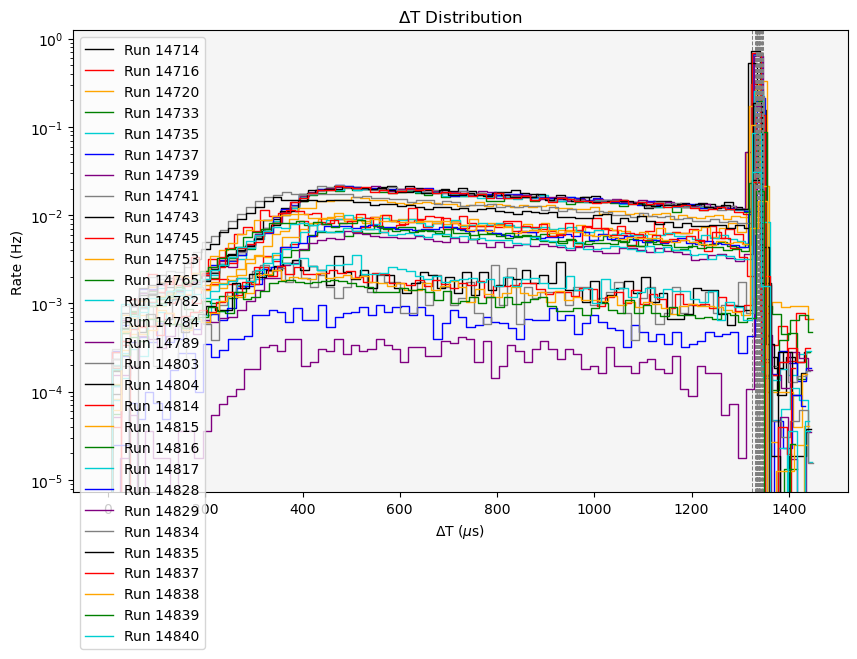

In [12]:
# Store important information
V_drift = {}                      # Drift velocities
m_DT    = {}                      # Slopes from linear fit

# Global
plt.figure(figsize=(10, 6))
n_bins = 80
DT_min = 600                      # Linear fit limits
DT_max = 0

for i, entry in enumerate(runs_info):
    
    # Run info    
    run_id   = entry["run_number"]
    # run_volt = entry[scan_key] / 1e3
    run_long = entry["duration"]
    run_DAQe = (entry["OK"] / (entry["OK"] + entry["LOST"]))
    
    # Variables
    DT = data[run_id]['DT']

    # Histogram: normalize by rate
    DT_counts, DT_bins = np.histogram(DT, bins=n_bins,  range=(0, DT.max()))
    DT_counts = DT_counts / (run_long * run_DAQe)
    
    # Estimated cathode time position + error
    cath_index   = np.argmax(DT_counts)                                                 # Index of the bin with the highest count
    cath_central = DT_bins[cath_index]
    cath_error   = (DT_bins[1] - DT_bins[0]) / 2
    
    # Drift velocity + error
    drift_vel       = (pt.N100_hei - pt.EL_gap) / cath_central
    drift_error     = drift_vel * (cath_error / cath_central)
    V_drift[run_id] = {'CV': drift_vel, 'Error': drift_error}
    
    print(f'Run {run_id}')
    print(f'Cathode time position = ({cath_central:.2f} +/- {cath_error:.2f}) μs')
    print(f'Drift velocity = ({drift_vel:.2f} +/- {drift_error:.2f}) mm/μs \n')
    
    # Plot the normalized histogram + cathode line
    plt.step(DT_bins[:-1], DT_counts, where='mid', 
             color=pt.hist_colors[i % len(pt.hist_colors)], 
             lw=1.0 , label=f'Run {run_id}')
    plt.axvline(x=cath_central, c='gray', ls='--', lw=0.75)                             # Cathode line
    
    # Linear fit
    DT_max = DT_stop[run_id]
    DT_centers, DT_fit = ff.prefit_1D(DT_bins, DT, DT_counts, DT_min, DT_max)
    
    popt, pcov = curve_fit(ff.linear_func, DT_centers, DT_fit)
    m_DT[run_id] = {'CV': popt[0], 'Error': np.sqrt(pcov[0, 0])}
    
    # Plot the fitted line
    fit_x = np.linspace(DT_centers.min(), DT_centers.max(), 100)
    fit_y = ff.linear_func(fit_x, *popt)
    #plt.plot(fit_x, fit_y, c='black', ls='--', lw=0.75)

#Plot
plt.xlabel('$\Delta$T ($\mu$s)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title(f'$\Delta$T Distribution')
plt.legend(loc='upper left')
 
plt.gca().set_facecolor("whitesmoke")
# plt.grid(True, ls='-', lw=0.75, alpha=0.5)
# plt.savefig(f'images/comparisons/DT_comparison.png', bbox_inches='tight')
plt.show()

#### Cathode HV dependence

In [13]:
# UNDER RE-CONSTRUCTION: task in Notion.

# # Store the slopes from the fits in a list
# voltages = []
# slopes   = []

# for entry in run_info:
    
#     run_i = entry['run_number']
    
#     if run_i in m_DT:
#         voltages.append(entry['voltage'] / 1e3)
#         slopes.  append(m_DT[run_i])
        
# # Plot
# plt.figure(figsize=(10, 6))
# plt.scatter(voltages, slopes, c='navy', zorder=3)
# plt.xlabel('Voltage (kV)')
# plt.ylabel('m (counts / $\mu$s)')
# plt.title('Slopes from the linear fit: $\Delta$T distribution')
# plt.axhline(y=0.0, color='red', linestyle='--', linewidth=1)

# plt.gca().set_facecolor("whitesmoke")
# plt.grid(True, linestyle='-', linewidth=0.75, alpha=0.5)
# plt.show()

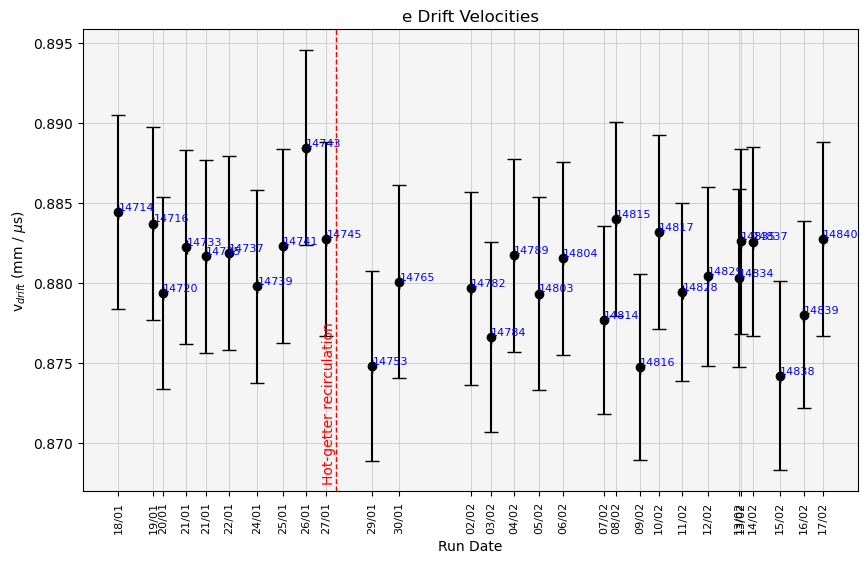

In [14]:
# Electron drift velocities comparison
run_date = []
voltages = []
#Vd_MC    = []                           # If there are MC values

plt.figure(figsize=(10, 6))

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    # run_volt = entry[scan_key] / 1e3
    run_long = entry["duration"]
    
    # Variables    
    Date = data[run_id]['time']
    
    # Retrieve e drift velocities values   
    Vd_CV    = V_drift[run_id]['CV']       # in [mm/μs]
    Vd_error = V_drift[run_id]['Error']
    
    # Mean date + error for each run
    Date_CV    = Date.mean()
    Date_error = Date.std() / np.sqrt(len(Date))
    run_date.append(Date_CV)
    # Or just voltages
    # voltages.append(run_volt)

    # Plot
    plt.errorbar(Date_CV, Vd_CV, xerr=Date_error, yerr=Vd_error,
                 fmt='o', c='black', ecolor='black', capsize=5, label='Data')
    plt.text(Date_CV, Vd_CV, str(run_id), fontsize=8, ha='left', va='bottom', color='blue')   # Run number near the point
    
# Convert x-axis bin edges to readable time format. Flatten all_run_x for custom tick setting
run_date = np.array(run_date)
x_labels = [crudo.epoch_converter(t, h=False) for t in run_date]
      
# Styling
#plt.scatter(voltages, Vd_MC, c='red', label='MC', zorder=3)
#plt.xlabel(f'{scan} High Voltage (kV)')
plt.xlabel('Run Date')
plt.xticks(run_date, x_labels, rotation=90, ha='center', fontsize=8)  
plt.ylabel('v$_{drift}$ (mm / $\mu$s)')
plt.title(f'e Drift Velocities')
plt.axvline(x=1737975600, c='red', ls='--', lw=1)
plt.text(1737975600, 0.8725, 'Hot-getter recirculation', c='red', va='center',  ha='right',  rotation=90)
#plt.legend()

plt.gca().set_facecolor("whitesmoke")
plt.grid(True, ls='-', lw=0.75, alpha=0.5)
plt.savefig(f'images/comparisons/drift_vel_com.png', bbox_inches='tight')
plt.show()

### Radial distribution

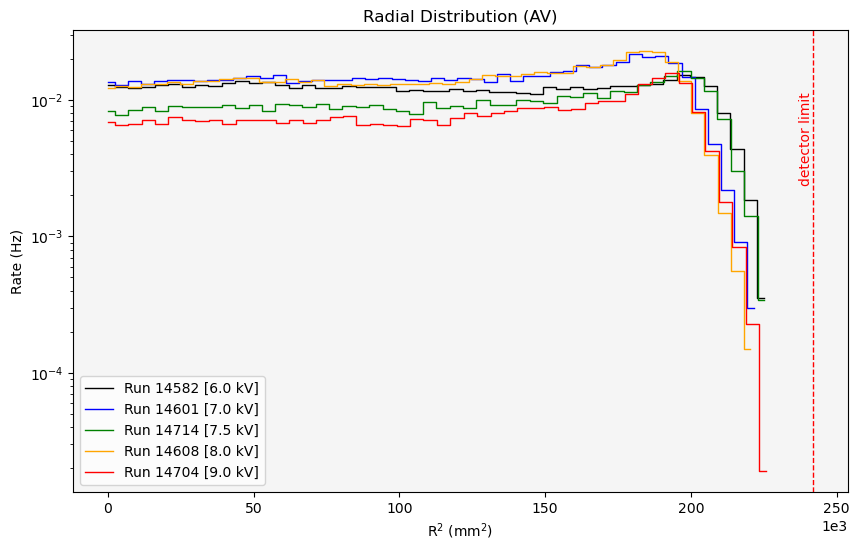

In [49]:
# Global
plt.figure(figsize=(10, 6))
n_bins = 50

for i, entry in enumerate(runs_info):
    
    ## Run info    
    run_id   = entry["run_number"]
    run_volt = entry[scan_key] / 1e3
    run_long = entry["duration"]
    
    # Variables
    R2 = data[run_id]['X']**2 + data[run_id]['Y']**2
    R2_mask = R2[AV_mask[run_id]]
    
    # Histogram: normalize by rate
    R2_counts, R2_bins = np.histogram(R2_mask, bins=n_bins)
    R2_counts = R2_counts / run_long
    
    # Plot the normalized histogram
    plt.step(R2_bins[:-1], R2_counts, where='mid', 
             color=pt.hist_colors[i % len(pt.hist_colors)], 
             lw=1.0 , label=f'Run {run_id} [{run_volt} kV]')
    
# Plot
plt.xlabel('R$^{2}$ (mm$^{2}$)')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title('Radial Distribution (AV)')
plt.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
plt.legend(loc='lower left')
# Radial limit
plt.axvline(x=pt.N100_rad**2, c='red', ls='--', lw=1)
plt.text(pt.N100_rad**2, 0.75*R2_counts[0], 'detector limit', c='red', va='center',  ha='right',  rotation=90)

plt.gca().set_facecolor("whitesmoke")
#plt.grid(True)
plt.show()

### Event distribution

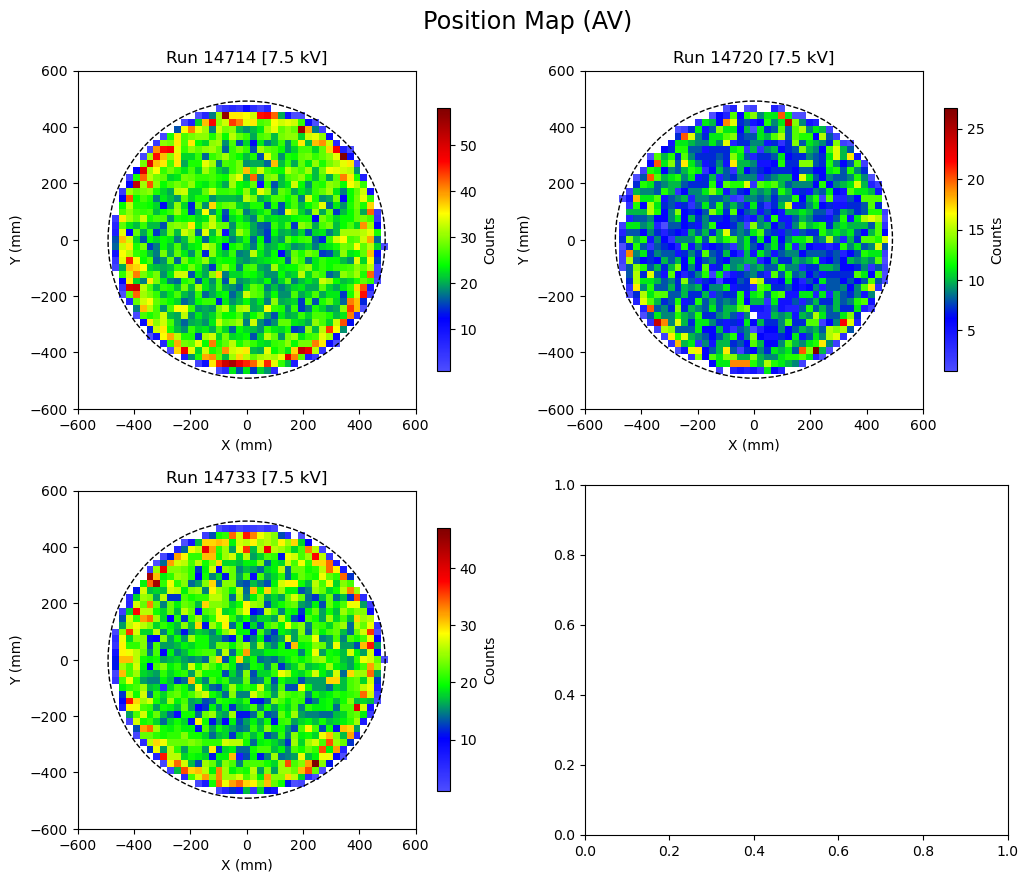

In [8]:
# Global
n_bins = 50

# Let's creat a matrix of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes      = axes.flatten()  

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_volt = entry[scan_key] / 1e3
    
    # Variables    
    X = data[run_id]['X']
    Y = data[run_id]['Y']
    X_mask = X[AV_mask[run_id]]
    Y_mask = Y[AV_mask[run_id]]
    
    # Map
    xy_map, ex, ey = pt.mapping(X_mask, Y_mask, xy_bins=n_bins, pos=True)
    xy_map         = np.ma.masked_where(xy_map==0, xy_map)                               # Zero values masked
    
    # Plots
    pcm = axes[i].pcolormesh(ex, ey, xy_map.T, cmap=pt.custom_hsv, shading='auto')
    fig.colorbar(pcm, ax=axes[i], label='Counts', shrink=0.75)
    axes[i].set_xlabel('X (mm)')
    axes[i].set_ylabel('Y (mm)')
    axes[i].set_title (f'Run {run_id} [{run_volt} kV]') 
    axes[i].add_patch(pt.plot_circle(pt.N100_rad))
    axes[i].set_aspect('equal', adjustable='box')
    
fig.suptitle('Position Map (AV)', x=0.5, y=0.935, fontsize='xx-large', color='black')
plt.savefig(f'images/comparisons/XYmap_{scan}_AV.png', bbox_inches='tight')
plt.show()

### Widths maps

#### $S1$w

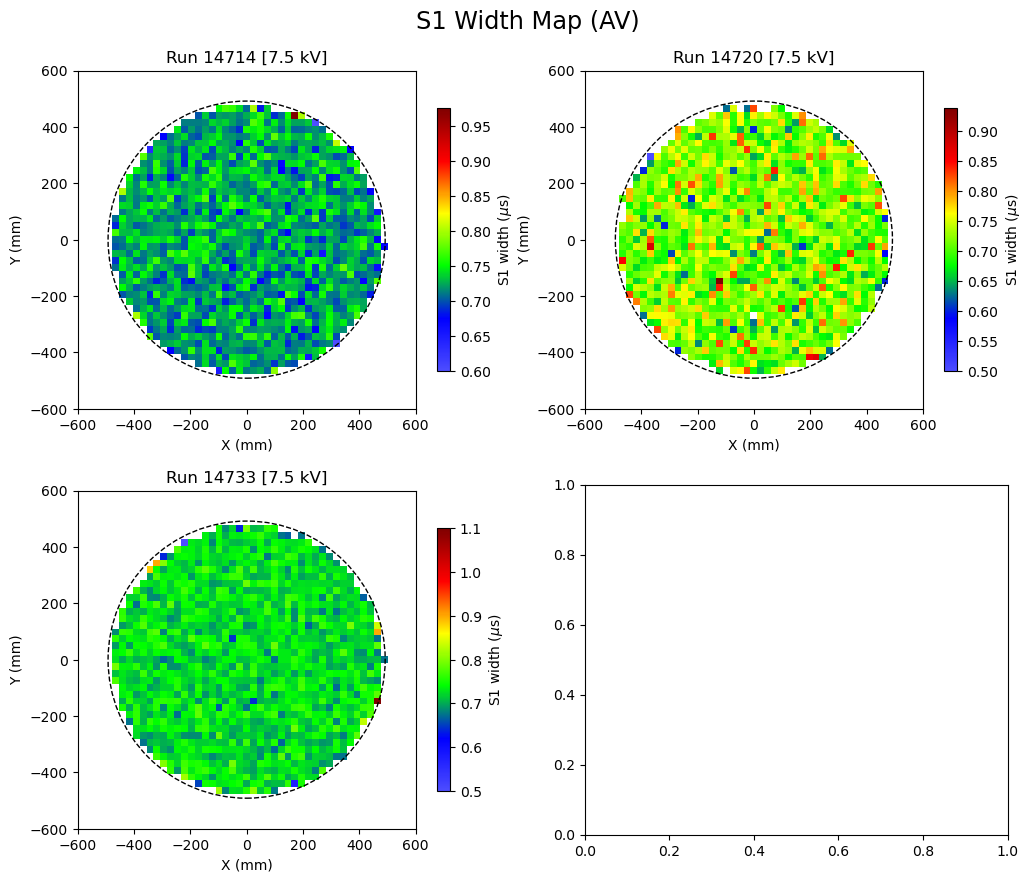

In [6]:
# Global
n_bins = 50

# Let's creat a matrix of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes      = axes.flatten()  

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_volt = entry[scan_key] / 1e3
    
    # Variables    
    X  = data[run_id]['X']
    Y  = data[run_id]['Y']
    W1 = data[run_id]['S1w'] / 1e3
    X_mask  = X[AV_mask[run_id]]
    Y_mask  = Y[AV_mask[run_id]]
    W1_mask = W1[AV_mask[run_id]]
    
    # Map
    S1w_map, ex, ey = pt.mapping(X_mask, Y_mask, wei=W1_mask, xy_bins=n_bins)
    S1w_map         = np.ma.masked_where(S1w_map==0, S1w_map)                               # Zero values masked
    
    # Plots
    pcm = axes[i].pcolormesh(ex, ey, S1w_map.T, cmap=pt.custom_hsv, shading='auto')
    fig.colorbar(pcm, ax=axes[i], label='S1 width ($\mu$s)', shrink=0.75)
    axes[i].set_xlabel('X (mm)')
    axes[i].set_ylabel('Y (mm)')
    axes[i].set_title (f'Run {run_id} [{run_volt} kV]') 
    axes[i].add_patch(pt.plot_circle(pt.N100_rad))
    axes[i].set_aspect('equal', adjustable='box')
    
fig.suptitle('S1 Width Map (AV)', x=0.5, y=0.935, fontsize='xx-large', color='black')
plt.savefig(f'images/comparisons/W1map_{scan}_AV.png', bbox_inches='tight')
plt.show()

#### $S2$w

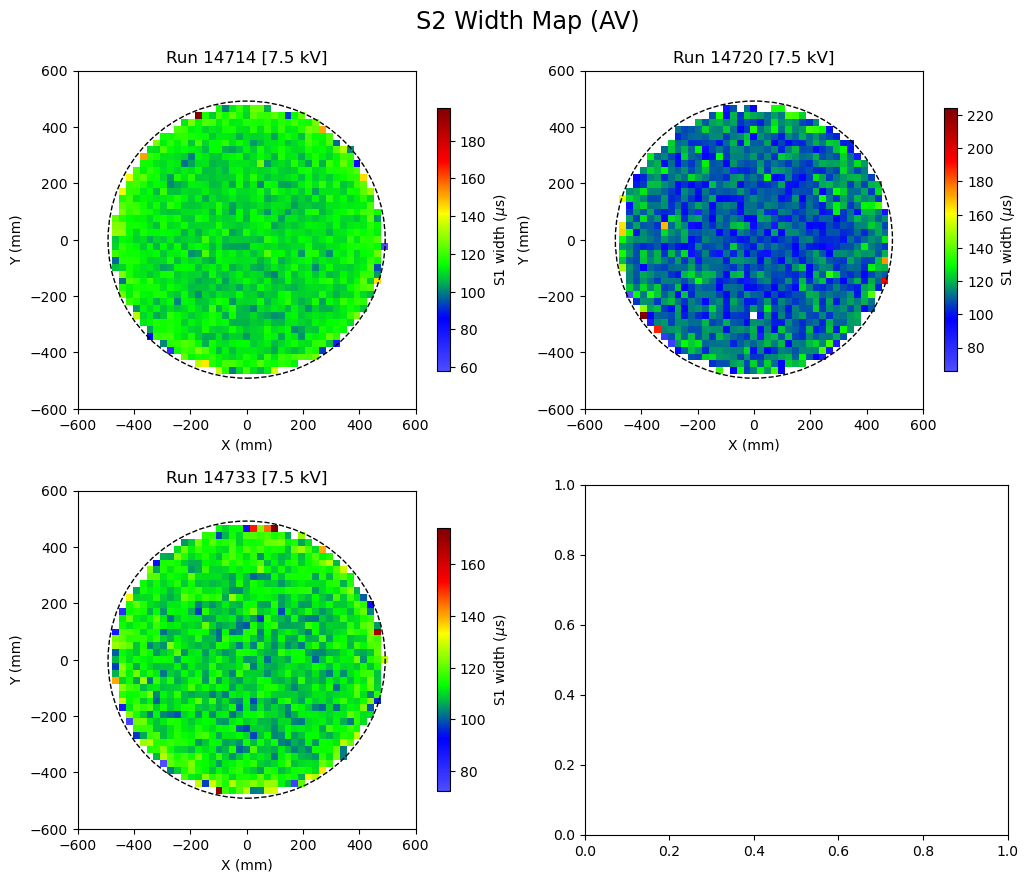

In [7]:
# Global
n_bins = 50

# Let's creat a matrix of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes      = axes.flatten()  

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_volt = entry[scan_key] / 1e3
    
    # Variables    
    X  = data[run_id]['X']
    Y  = data[run_id]['Y']
    W2 = data[run_id]['S2w']
    X_mask  = X[AV_mask[run_id]]
    Y_mask  = Y[AV_mask[run_id]]
    W2_mask = W2[AV_mask[run_id]]
    
    # Map
    S2w_map, ex, ey = pt.mapping(X_mask, Y_mask, wei=W2_mask, xy_bins=n_bins)
    S2w_map         = np.ma.masked_where(S2w_map==0, S2w_map)                               # Zero values masked
    
    # Plots
    pcm = axes[i].pcolormesh(ex, ey, S2w_map.T, cmap=pt.custom_hsv, shading='auto')
    fig.colorbar(pcm, ax=axes[i], label='S1 width ($\mu$s)', shrink=0.75)
    axes[i].set_xlabel('X (mm)')
    axes[i].set_ylabel('Y (mm)')
    axes[i].set_title (f'Run {run_id} [{run_volt} kV]') 
    axes[i].add_patch(pt.plot_circle(pt.N100_rad))
    axes[i].set_aspect('equal', adjustable='box')
    
fig.suptitle('S2 Width Map (AV)', x=0.5, y=0.935, fontsize='xx-large', color='black')
plt.savefig(f'images/comparisons/W2map_{scan}_AV.png', bbox_inches='tight')
plt.show()

### Energy maps

#### $S1$e

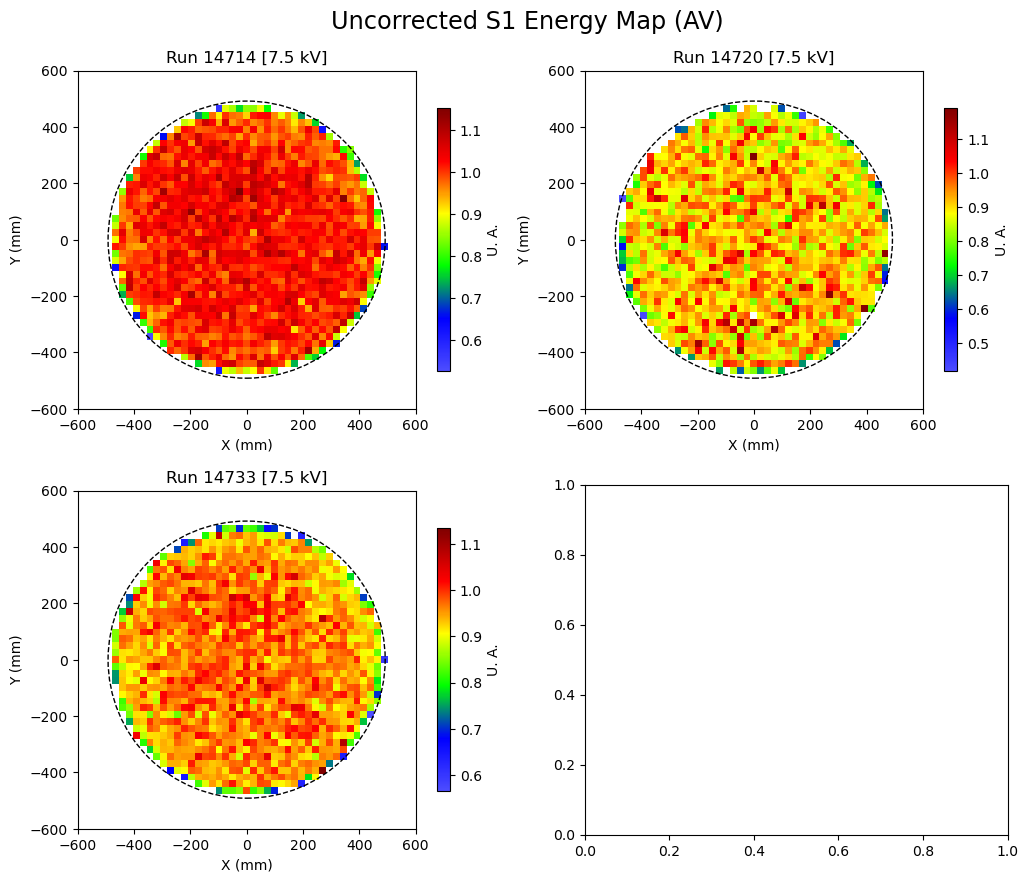

In [5]:
# Global
n_bins = 50

# Let's creat a matrix of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes      = axes.flatten()  

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_volt = entry[scan_key] / 1e3
    
    # Variables    
    X  = data[run_id]['X']
    Y  = data[run_id]['Y']
    E1 = data[run_id]['S1e']
    X_mask  = X[AV_mask[run_id]]
    Y_mask  = Y[AV_mask[run_id]]
    E1_mask = E1[AV_mask[run_id]]
    
    # Map
    S1e_map, ex, ey = pt.mapping(X_mask, Y_mask, wei=E1_mask, xy_bins=n_bins, norm=True)
    S1e_map         = np.ma.masked_where(S1e_map==0, S1e_map)                               # Zero values masked
    
    # Plots
    pcm = axes[i].pcolormesh(ex, ey, S1e_map.T, cmap=pt.custom_hsv, shading='auto')
    fig.colorbar(pcm, ax=axes[i], label='U. A.', shrink=0.75)
    axes[i].set_xlabel('X (mm)')
    axes[i].set_ylabel('Y (mm)')
    axes[i].set_title (f'Run {run_id} [{run_volt} kV]') 
    axes[i].add_patch(pt.plot_circle(pt.N100_rad))
    axes[i].set_aspect('equal', adjustable='box')
    
fig.suptitle('Uncorrected S1 Energy Map (AV)', x=0.5, y=0.935, fontsize='xx-large', color='black')
plt.savefig(f'images/comparisons/E1map_{scan}_AV.png', bbox_inches='tight')
plt.show()

#### $S2$e

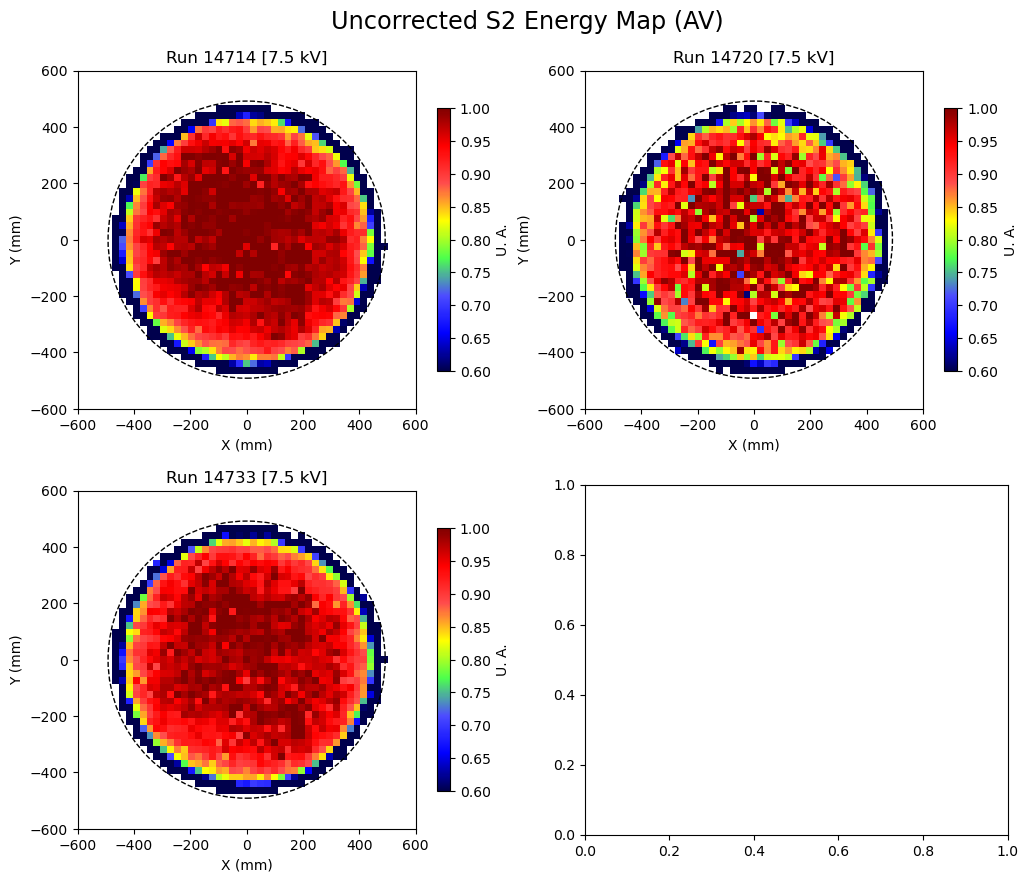

In [61]:
# Global
n_bins = 50

# Let's creat a matrix of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes      = axes.flatten()  

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_volt = entry[scan_key] / 1e3
    
    # Variables    
    X  = data[run_id]['X']
    Y  = data[run_id]['Y']
    E2 = data[run_id]['S2e']
    X_mask  = X[AV_mask[run_id]]
    Y_mask  = Y[AV_mask[run_id]]
    E2_mask = E2[AV_mask[run_id]]
    
    # Map
    S2e_map, ex, ey = pt.mapping(X_mask, Y_mask, wei=E2_mask, xy_bins=n_bins, norm=True)
    S2e_map         = np.ma.masked_where(S2e_map==0, S2e_map)                               # Zero values masked
    S2e_map         = np.clip(S2e_map, 0.6, 1.0)                                            # Clipped values in colorbar
    
    # Plots
    pcm = axes[i].pcolormesh(ex, ey, S2e_map.T, cmap=pt.custom_hsv, shading='auto')
    fig.colorbar(pcm, ax=axes[i], label='U. A.', shrink=0.75)
    axes[i].set_xlabel('X (mm)')
    axes[i].set_ylabel('Y (mm)')
    axes[i].set_title (f'Run {run_id} [{run_volt} kV]') 
    axes[i].add_patch(pt.plot_circle(pt.N100_rad))
    axes[i].set_aspect('equal', adjustable='box')
    
fig.suptitle('Uncorrected S2 Energy Map (AV)', x=0.5, y=0.935, fontsize='xx-large', color='black')
plt.savefig(f'images/comparisons/E2map_{scan}_AV.png', bbox_inches='tight')
plt.show()

### Longitudinal dependence

#### $S1$e

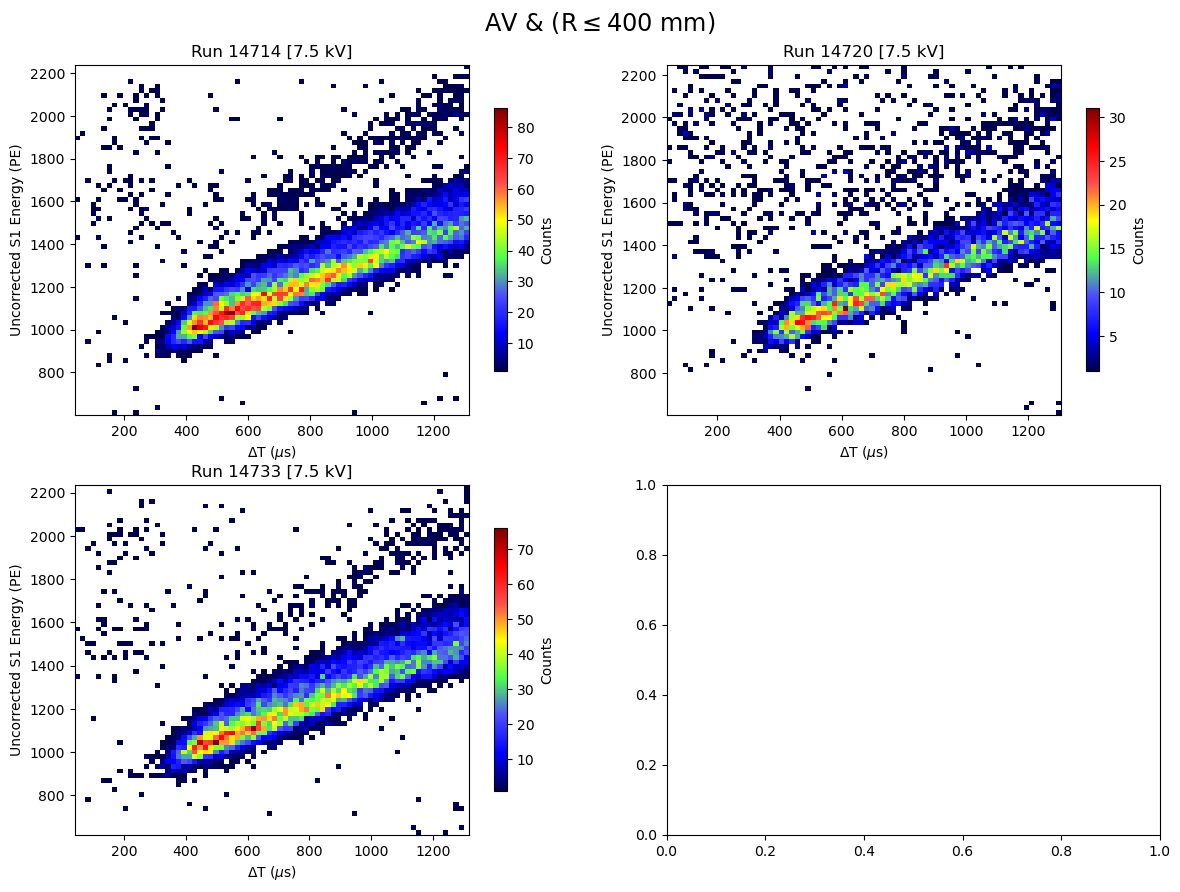

In [62]:
# Global
rad_lim = 400
n_bins  = 75

# Let's creat a matrix of plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes      = axes.flatten()  

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_volt = entry[scan_key] / 1e3
    
    # Variables    
    E1 = data[run_id]['S1e']
    DT = data[run_id]['DT']
    R  = data[run_id]['R']
    
    # Masking
    rad_mask = (R <= rad_lim)
    E1_mask  = E1[AV_mask[run_id] & rad_mask]
    DT_mask  = DT[AV_mask[run_id] & rad_mask]
    
    # 2D histogram
    S1e_DT_map, ex, ey = pt.hist_2D(DT_mask, E1_mask, x_bins=n_bins, y_bins=n_bins)
    S1e_DT_map         = np.ma.masked_where(S1e_DT_map==0, S1e_DT_map)                               # Zero values masked
    
    # Plots
    pcm = axes[i].pcolormesh(ex, ey, S1e_DT_map.T, cmap=pt.custom_hsv, shading='auto')
    fig.colorbar(pcm, ax=axes[i], label='Counts', shrink=0.75)
    axes[i].set_xlabel('$\Delta$T ($\mu$s)')
    axes[i].set_ylabel('Uncorrected S1 Energy (PE)')
    axes[i].set_title (f'Run {run_id} [{run_volt} kV]')
    
fig.suptitle(f'AV & (R$\\leq${rad_lim} mm)', x=0.5, y=0.935, fontsize='xx-large', color='black')
plt.savefig(f'images/comparisons/S1e_DT_{scan}_AV.png', bbox_inches='tight')
plt.show()

#### $S2$e: lifetime

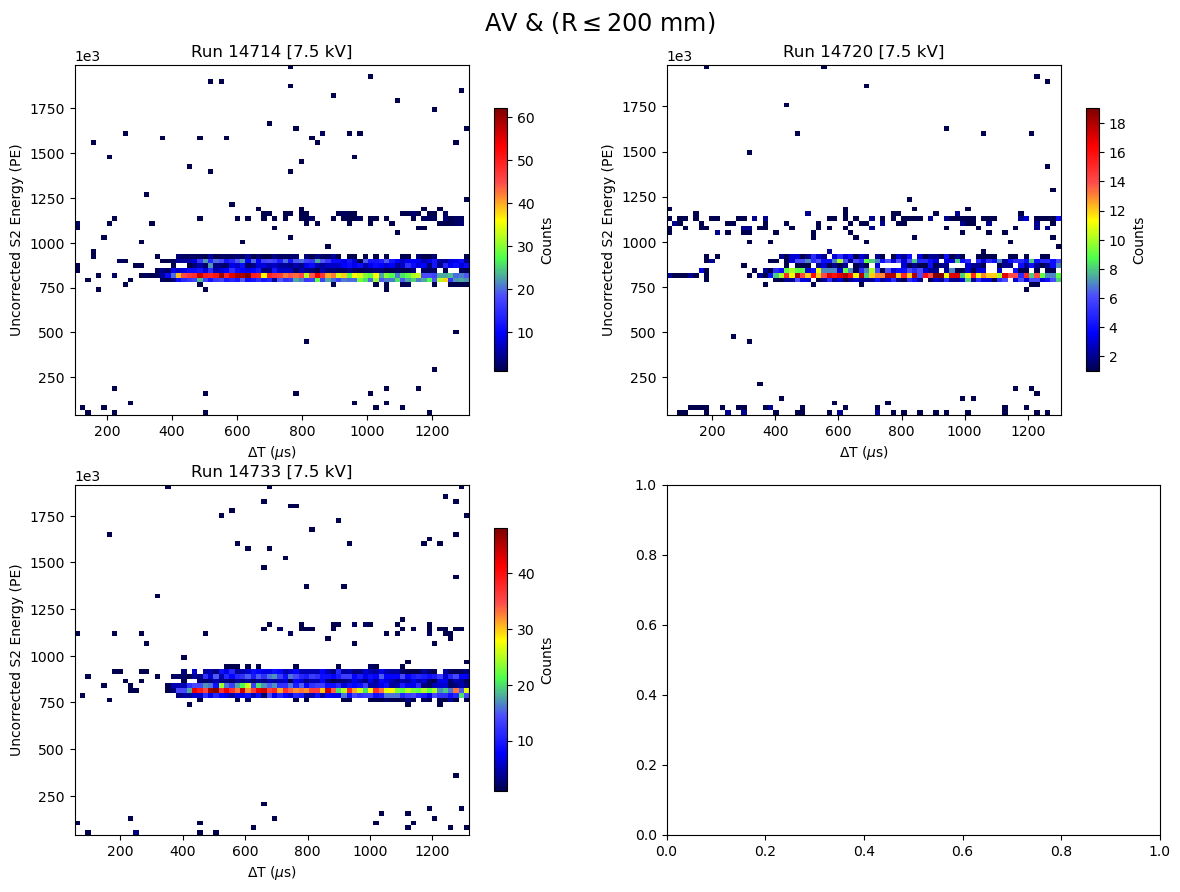

In [63]:
# Global
rad_lim = 200
n_bins  = 75

# Let's creat a matrix of plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes      = axes.flatten()  

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_volt = entry[scan_key] / 1e3
    
    # Variables    
    E2 = data[run_id]['S2e']
    DT = data[run_id]['DT']
    R  = data[run_id]['R']
    
    # Masking
    rad_mask = (R <= rad_lim)
    E2_mask  = E2[AV_mask[run_id] & rad_mask]
    DT_mask  = DT[AV_mask[run_id] & rad_mask]
    
    # 2D histogram
    S2e_DT_map, ex, ey = pt.hist_2D(DT_mask, E2_mask, x_bins=n_bins, y_bins=n_bins)
    S2e_DT_map         = np.ma.masked_where(S2e_DT_map==0, S2e_DT_map)                               # Zero values masked
    
    # Plots
    pcm = axes[i].pcolormesh(ex, ey, S2e_DT_map.T, cmap=pt.custom_hsv, shading='auto')
    fig.colorbar(pcm, ax=axes[i], label='Counts', shrink=0.75)
    axes[i].set_xlabel('$\Delta$T ($\mu$s)')
    axes[i].set_ylabel('Uncorrected S2 Energy (PE)')
    axes[i].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
    axes[i].set_title (f'Run {run_id} [{run_volt} kV]')
    
fig.suptitle(f'AV & (R$\\leq${rad_lim} mm)', x=0.5, y=0.935, fontsize='xx-large', color='black')
plt.savefig(f'images/comparisons/S2e_DT_{scan}_AV.png', bbox_inches='tight')
plt.show()

### Radial dependence

#### $S2$e

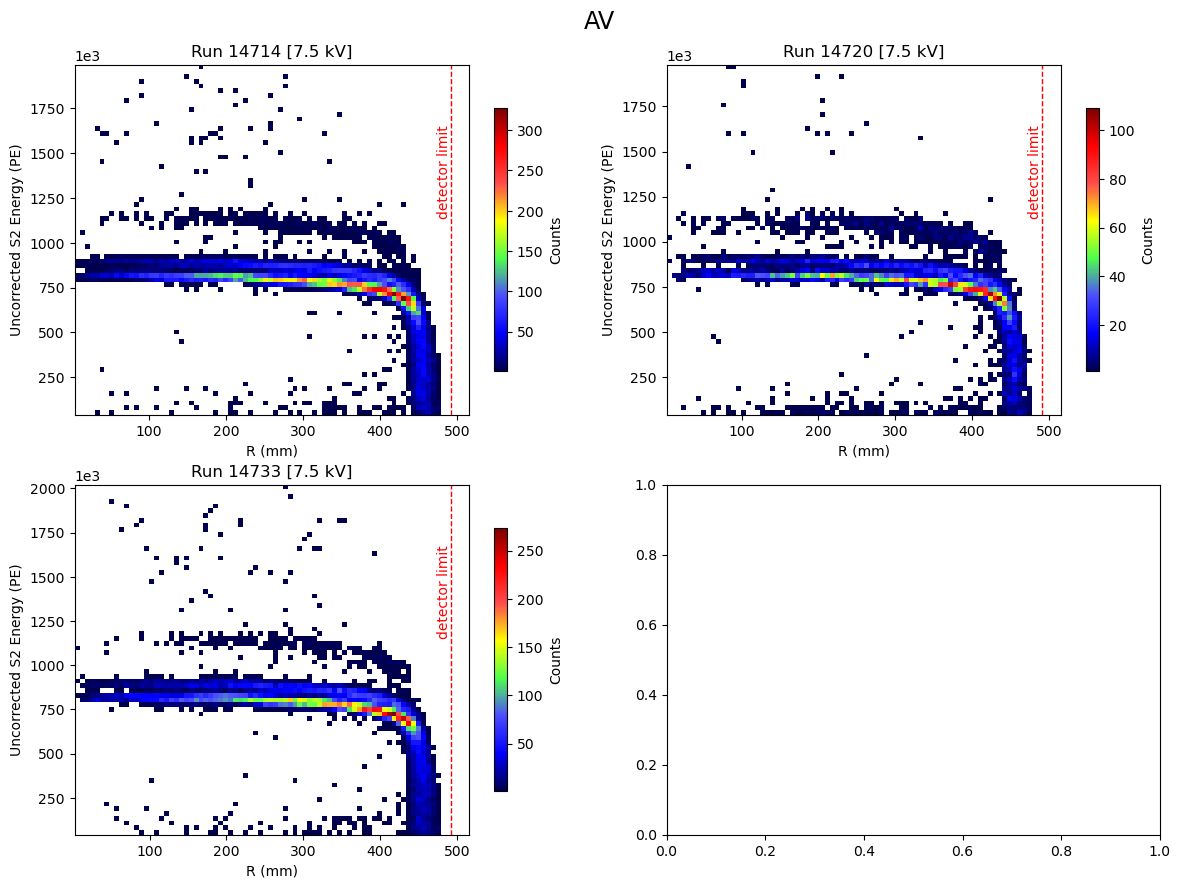

In [64]:
# Global
n_bins = 75

# Let's creat a matrix of plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes      = axes.flatten()  

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_volt = entry[scan_key] / 1e3
    
    # Variables    
    E2 = data[run_id]['S2e']
    R  = data[run_id]['R']
    
    # Masking
    E2_mask = E2[AV_mask[run_id]]
    R_mask  = R[AV_mask[run_id]]
    
    # 2D histogram
    S2e_R_map, ex, ey = pt.hist_2D(R_mask, E2_mask, x_bins=n_bins, y_bins=n_bins)
    S2e_R_map         = np.ma.masked_where(S2e_R_map==0, S2e_R_map)                               # Zero values masked
    
    # Plots
    pcm = axes[i].pcolormesh(ex, ey, S2e_R_map.T, cmap=pt.custom_hsv, shading='auto')
    fig.colorbar(pcm, ax=axes[i], label='Counts', shrink=0.75)
    axes[i].set_xlabel('R (mm)')
    axes[i].set_ylabel('Uncorrected S2 Energy (PE)')
    axes[i].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
    axes[i].set_title (f'Run {run_id} [{run_volt} kV]')
    # Radial limit
    axes[i].axvline(x=pt.N100_rad, c='red', ls='--', lw=1)
    axes[i].text(pt.N100_rad, 0.7*E2_mask.max(), 'detector limit', c='red', va='center',  ha='right',  rotation=90)
    
fig.suptitle(f'AV', x=0.5, y=0.935, fontsize='xx-large', color='black')
plt.savefig(f'images/comparisons/S2e_R_{scan}_AV.png', bbox_inches='tight')
plt.show()

#### $S1$e vs $S2$e

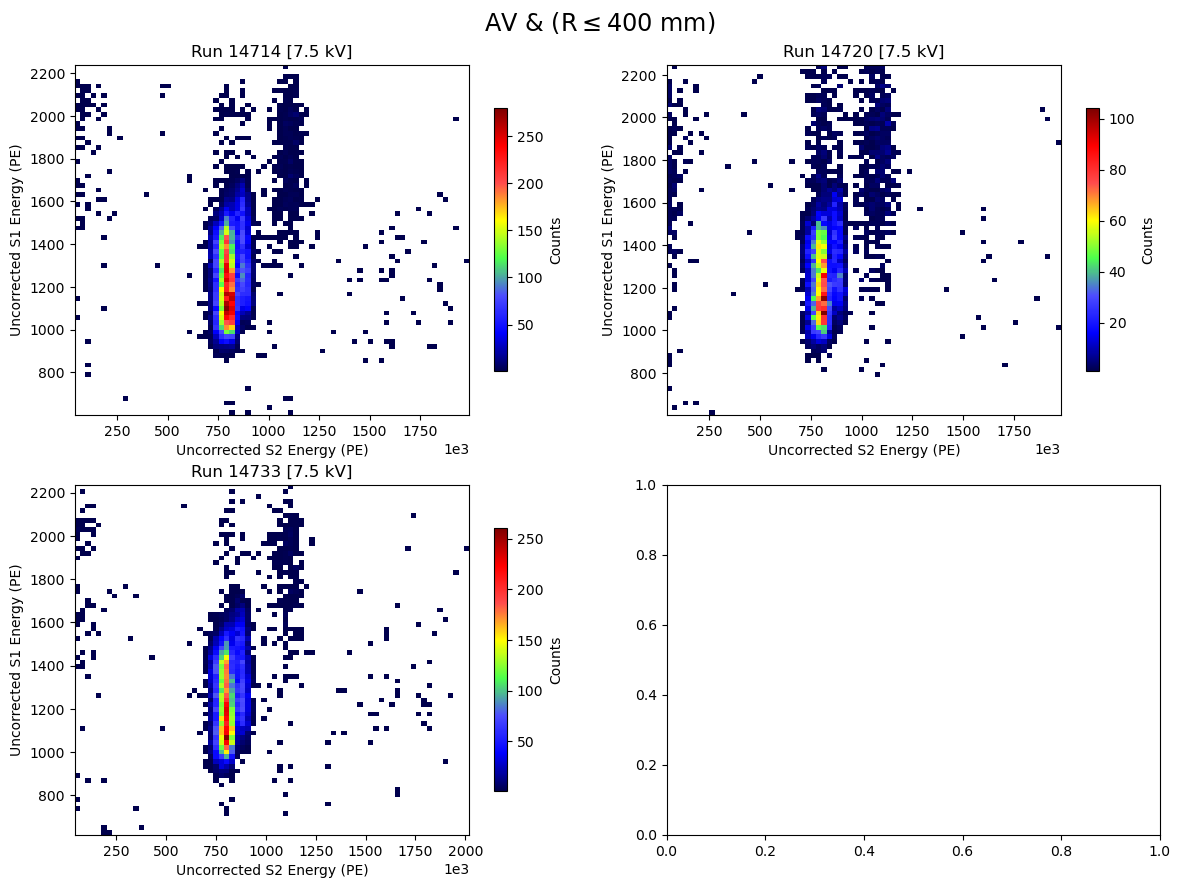

In [65]:
# Global
rad_lim = 400
n_bins  = 75

# Let's creat a matrix of plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes      = axes.flatten()  

for i, entry in enumerate(runs_info):
    
    # Run info
    run_id   = entry["run_number"]
    run_volt = entry[scan_key] / 1e3
    
    # Variables    
    E1 = data[run_id]['S1e']
    E2 = data[run_id]['S2e']
    R  = data[run_id]['R']
    
    # Masking
    rad_mask = (R <= rad_lim)
    E1_mask  = E1[AV_mask[run_id] & rad_mask]
    E2_mask  = E2[AV_mask[run_id] & rad_mask]
    
    # 2D histogram
    S1e_S2e_map, ex, ey = pt.hist_2D(E2_mask, E1_mask, x_bins=n_bins, y_bins=n_bins)
    S1e_S2e_map         = np.ma.masked_where(S1e_S2e_map==0, S1e_S2e_map)                               # Zero values masked
    
    # Plots
    pcm = axes[i].pcolormesh(ex, ey, S1e_S2e_map.T, cmap=pt.custom_hsv, shading='auto')
    fig.colorbar(pcm, ax=axes[i], label='Counts', shrink=0.75)
    axes[i].set_xlabel('Uncorrected S2 Energy (PE)')
    axes[i].set_ylabel('Uncorrected S1 Energy (PE)')
    axes[i].ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
    axes[i].set_title (f'Run {run_id} [{run_volt} kV]')
    
fig.suptitle(f'AV & (R$\\leq${rad_lim} mm)', x=0.5, y=0.935, fontsize='xx-large', color='black')
plt.savefig(f'images/comparisons/S1e_S2e_{scan}_AV.png', bbox_inches='tight')
plt.show()